# Examen Final Práctico - Daniel Crovo

El problema se origina al digitalizar documentos provenientes de una fuente histórica, como archivos antiguos, bibliotecas o museos, que contienen valiosa información, pero que presentan ruido y deterioro debido al paso del tiempo y las condiciones de almacenamiento. Estos documentos pueden ser manuscritos, cartas, diarios u otros registros históricos que han sido escaneados en baja calidad, lo que dificulta su legibilidad y comprensión. El objetivo se basa en desarrollar dos (2) modelos de procesamiento de imágenes capaces de denoizar y mejorar la calidad de los documentos escaneados provenientes de fuentes históricas. Se busca eliminar el ruido, las manchas, las arrugas y otros artefactos que afectan la legibilidad de los documentos, preservando al mismo tiempo su valor histórico y contenido original.

In [1]:
from torch.utils.data import Dataset, DataLoader
import os 
import numpy as np
from PIL import Image
import multiprocessing
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from torchmetrics import PeakSignalNoiseRatio,MeanSquaredError
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import math
torch.manual_seed(0)
from typing import Sequence, Union, Tuple
import optuna


In [2]:
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240
NOISY_PATH = '../train/'
CLEAN_PATH = '../train_cleaned/'
VAL_PATH = '../test/'
SAVE_PATH = '../preds/'
NUM_WORKERS = multiprocessing.cpu_count()
IN_CHANNELS = 1
FEATURE_SIZE = 128
KERNEL_SIZE = 3
PADDING = 1
BATCH_SIZE = 16
PIN_MEMORY =  True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 200
LR = 0.0001
psnr = PeakSignalNoiseRatio().to(DEVICE)
mse = MeanSquaredError().to(DEVICE)

## Data Understanding and preparation

In [3]:
class NoisyTrainData(Dataset):
    """ Dataset para gestionar las imagenes limpias y sucias
        especificamente para entrenamiento
    """
    
    def __init__(self, noisy_image_dir, clean_image_dir, transform=None):
        """ Inicializa el dataset de entrenamiento.

        Parameters:
            noisy_image_dir (str): Path del directorio de las imagenes con ruido
            clean_image_dir (str): Path del directorio de las imagenes limpias
            transform (str): Recibe un objeto para aumentación de las imágenes
        
        """
        self.noisy_image_dir = noisy_image_dir
        self.clean_image_dir = clean_image_dir
        self.transform = transform
        self.noisy_images = sorted(os.listdir(noisy_image_dir))
        self.clean_images = sorted(os.listdir(clean_image_dir))
    
    def __len__(self):
        #Return lenght of the dataset
        return len(self.clean_images)
    
    def __getitem__(self, index):
        """
        Retorna una tupla de tensores que representan la imagen limpia y con ruido
        Returns:

        clean_image (Tensor): La imagen sin ruido post transformación
        noisy_image (Tensor): La imagen sin ruido post transformación 
 
        """
        clean_img_path = os.path.join(self.clean_image_dir, self.clean_images[index])
        noisy_img_path = os.path.join(self.noisy_image_dir, self.noisy_images[index])
        clean_image = np.array(Image.open(clean_img_path).convert('L'))
        noisy_image = np.array(Image.open(noisy_img_path).convert('L'))

        
        if self.transform is not None: 
            transformations = self.transform(image = clean_image, noisy_image = noisy_image)
            clean_image = transformations['image']
            noisy_image = transformations['noisy_image']

        return clean_image, noisy_image

class NoisyValData(Dataset):
    '''
        Dataset par gestionar el set de pruebas
    '''
    def __init__(self, val_dir, transform=None):
        self.val_dir = val_dir
        self.transform = transform
        self.images = sorted(os.listdir(val_dir))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.val_dir, self.images[index])
        image = np.array(Image.open(img_path).convert('L'))

        if self.transform is not None:
            transformations = self.transform(image = image)
            image = transformations['image']
        return image

In [4]:
def getLoaders(clean_dir, noisy_dir, val_dir, batch_size, 
               train_transform, val_transform, num_workers, 
               pin_memory):
    '''
        Función para obtener los dataloaders, se crea un set de validación que proviene de las imagenes limpias y con ruido
        para calcular la métricas psnr

        Returns: 
            train_loader (DataLoader): 
            test_loader (DataLoader): 
            val_loader (DataLoader):
    '''
    train_dataset = NoisyTrainData(noisy_image_dir=noisy_dir, clean_image_dir=clean_dir, transform= train_transform)
    train, val = random_split(train_dataset, [0.9, 0.1])
    train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
    val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
    test_dataset = NoisyValData(val_dir=val_dir, transform = val_transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, test_loader, val_loader

In [5]:
# Se aplican transformaciones teniendo en cuenta que el dataset no es grande
train_transforms = A.Compose(
    [   A.Resize(height= IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit = 50, p = 1.0), 
        A.HorizontalFlip(p = 0.3), 
        A.VerticalFlip(p = 0.1), 
        A.Normalize(
                    mean = [0.0],
                    std = [1.0], 
                    max_pixel_value = 255.0
                    ),
     ToTensorV2(),],
     additional_targets={'noisy_image': 'image' }
)
val_transforms = A.Compose(
    [A.Resize(height= IMAGE_HEIGHT, width=IMAGE_WIDTH),
     A.Normalize(
                mean = [0.0],
                std = [1.0], 
                max_pixel_value = 255.0
                ),
     ToTensorV2(),],
)

In [6]:
train_loader, test_loader, val_loader = getLoaders(CLEAN_PATH, NOISY_PATH, VAL_PATH, BATCH_SIZE,train_transforms, val_transforms, num_workers=NUM_WORKERS, pin_memory= PIN_MEMORY)

# 1. Aprendizaje no supervisado (Denoising Convolutional Autoencoder)

## Modelado 
Se realiazron pruebas con los siguientes modelos sin tener resultados buenos (no generaban imágenes similares a lo esperado):
- Autoencoder basado en capas completamente conectadas
- Autoencoder con capas convolucionales en el encoder que se conectan a una completamente conectada para generar la represantación latente
Por lo cual se decidió implementar un autoencoder convolucional sin capas completamente conectadas.

Se iniciaron pruebas con 2, 3 capas, pero el mejor rendimiento lo obtubo el de 4. el encoder cuenta con 4 capas convolucionales y cada una consiste en: Concolucion, Normalización, Relu, y cada dos capas se aplica Max pool para reducir la dimensionalidad.  

In [7]:
class DAE(nn.Module):
    def __init__(self, in_channels, feature_size, kernel_size, padding):
        super(DAE, self).__init__()
        self.inconv2 = feature_size
        self.outconv2 = int(feature_size / 2)
        self.inconv3 = self.outconv2
        self.outconv3 = int(self.outconv2 / 2)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=feature_size, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=self.inconv2, out_channels=self.outconv2, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(self.outconv2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=self.inconv3, out_channels=self.outconv3, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(self.outconv3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=self.outconv3, out_channels=int(self.outconv3/2), kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(int(self.outconv3/2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            

            
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(int(self.outconv3/2), self.inconv3, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(self.inconv3),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.inconv3, self.outconv3, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(self.outconv3),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.outconv3, self.outconv2, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(self.outconv2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.outconv2, self.inconv2, kernel_size=kernel_size, padding=padding, stride=2, output_padding=1),
            nn.BatchNorm2d(self.inconv2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.inconv2, in_channels, kernel_size=kernel_size, padding=padding, stride=2,
                               output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        return x
    

In [8]:
# Modelo base DAE.
model = DAE(in_channels=IN_CHANNELS,
            feature_size=FEATURE_SIZE, 
            kernel_size=KERNEL_SIZE, 
            padding=PADDING)
print(model)

DAE(
  (encoder): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(

## Entrenamiento
En esta fase se crean las funciones de entrenamiento para evaluar el modelo de aprendizaje no supervisado

In [7]:
def save_checkpoint(state, filename): 
    try:
        torch.save(state, filename)
        #print('Checkpoint saved succesfully')
    except:
        print('Error saving the checkpoint')

In [8]:
def train_func(train_loader, model, optimizer, loss_fn, scaler, device, epoch):
    model.to(device)
    #p_bar = tqdm(train_loader)
    running_loss = 0.0
    model.train()
    for batch_idx, (clean_img, noisy_img) in enumerate(train_loader):
        clean_img = clean_img.float()
        noisy_img = noisy_img.float()
        clean_img, noisy_img = clean_img.to(device = device), noisy_img.to(device=device)
       
        #Forward pass
        with torch.cuda.amp.autocast():
            preds = model(noisy_img)
            preds = preds.float()
            loss = loss_fn(preds, clean_img)


        #Backward Pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        torch.cuda.empty_cache()
        #print('Epoch: ', epoch)
        #p_bar.set_postfix(loss=loss.item())
        clean_img.cpu()
        noisy_img.cpu()
    model.cpu()
    epoch_loss = running_loss/len(train_loader)
    return epoch_loss

In [9]:
def performance_test(test_loader, model, device, folder):
    model.to(device)

    model.eval()        

    psnr_list = []
    with torch.no_grad():
        for test_img in test_loader:
            test_img = test_img.float()

            test_img = test_img.to(device = device)
            preds = model(test_img)
            #loss = loss_fn(preds, clean _img)
            psnr_value = psnr(preds, test_img)

            
            psnr_list.append(psnr(preds, test_img))
            ##print(f'signal to noise ratio: {psnr_value}')
            torch.cuda.empty_cache()
            test_img.cpu()
            preds.cpu()


    model.cpu()
    return psnr_list


In [10]:
def performance_val(val_loader, model, device, folder):
    model.to(device)
    model.eval()
    psnr_list = []
    psnr_val = 0.0
    mse_val = 0.0
    mse_list = []
    with torch.no_grad():
        for clean_img, noisy_img in val_loader:
            
            clean_img = clean_img.float()
            noisy_img = noisy_img.float()

            clean_img = clean_img.to(device = device)
            noisy_img = noisy_img.to(device = device)
            
            preds = model(noisy_img)
            #loss = loss_fn(preds, clean _img)
            psnr_val += psnr(preds, clean_img)
            mse_val += mse(preds, clean_img)
            
            psnr_list.append(psnr(preds, clean_img))
            mse_list.append(mse_val)
            ##print(f'signal to noise ratio: {psnr_value}')
            torch.cuda.empty_cache()
            clean_img.cpu()
            noisy_img.cpu()

    psnr_avg = psnr_val/len(psnr_list)
    mse_avg = mse_val/len(mse_list)
    model.cpu()

    return psnr_avg, mse_avg, psnr_list, mse_list

In [11]:
def save_preds_as_imgs(loader, model, device, folder ): 
    model.to(device)
    model.eval()
    for idx, (x) in enumerate(loader):
        x = x.to(device = device)
        with torch.no_grad(): # deshabilitar el cálculo y almacenamiento de gradientes en el grafo computacional de PyTorch
            x=x.float()
            preds = (model(x))
        torchvision.utils.save_image(preds, f'{folder}/y_cleaned_{idx}.png') # #almacenamiento de imagenes procesadas
        torchvision.utils.save_image(x.to(torch.float32), f'{folder}/y_noisy_{idx}.png') # almacenamiento de mimagenes con ruido
        torch.cuda.empty_cache()

    model.train()
    model.cpu()

Se entrena el modelo base del DAE por 200 epocas

In [15]:

optimizer = optim.Adam(model.parameters(), lr=LR) 
loss_fn = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()
eval_psnr =[]
eval_mse = []
train_loss = []
checkpoint_path = '../working/'
p_bar = tqdm(range(EPOCHS))
for epoch in p_bar:
    #print('________________________________________\nEpoch: ', epoch)
    train_loss.append(train_func(train_loader, model, optimizer, loss_fn, scaler, DEVICE, epoch))
    psnr_avg, mse_avg, psnr_list, mse_list = performance_val(val_loader, model, DEVICE, SAVE_PATH)
    eval_psnr.append(psnr_avg)
    eval_mse.append(mse_avg)
    save_preds_as_imgs(test_loader, model, DEVICE, SAVE_PATH) 
    checkpoint ={
                    'state_dict' : model.state_dict(),
                    'optimizer' : optimizer.state_dict()
                }
    filename = checkpoint_path+'checkpoint_'+str(epoch)+'.pth.tar'
    save_checkpoint(checkpoint, filename)
    p_bar.set_postfix(loss=train_loss[-1])
print(f'_____________Evaluation Metrics___________\n')
print(f'Peak Signal to Noise Ratio in val set: {eval_psnr[-1]}')
print(f'MSE: {eval_mse[-1]}')

  0%|          | 0/200 [00:00<?, ?it/s]

_____________Evaluation Metrics___________

Peak Signal to Noise Ratio in val set: 16.24721336364746
MSE: 0.023728951811790466


# Evaluación
Durante cada epoca el modela se evalua en el set de validación así como se realiza una predicción de las imágenes del set de pruebas y se almacenan en el disco duro para visualizar

El resultado de la métrica Peak Signal To Noise Ratio y el MSE en el set de validación es: 

```
Peak Signal to Noise Ratio in val set: 16.24721336364746
MSE: 0.023728951811790466
```

In [24]:
eval_mse = [tensor.cpu() for tensor in eval_mse]
eval_psnr = [tensor.cpu() for tensor in eval_psnr]

Text(0, 0.5, 'PSNR')

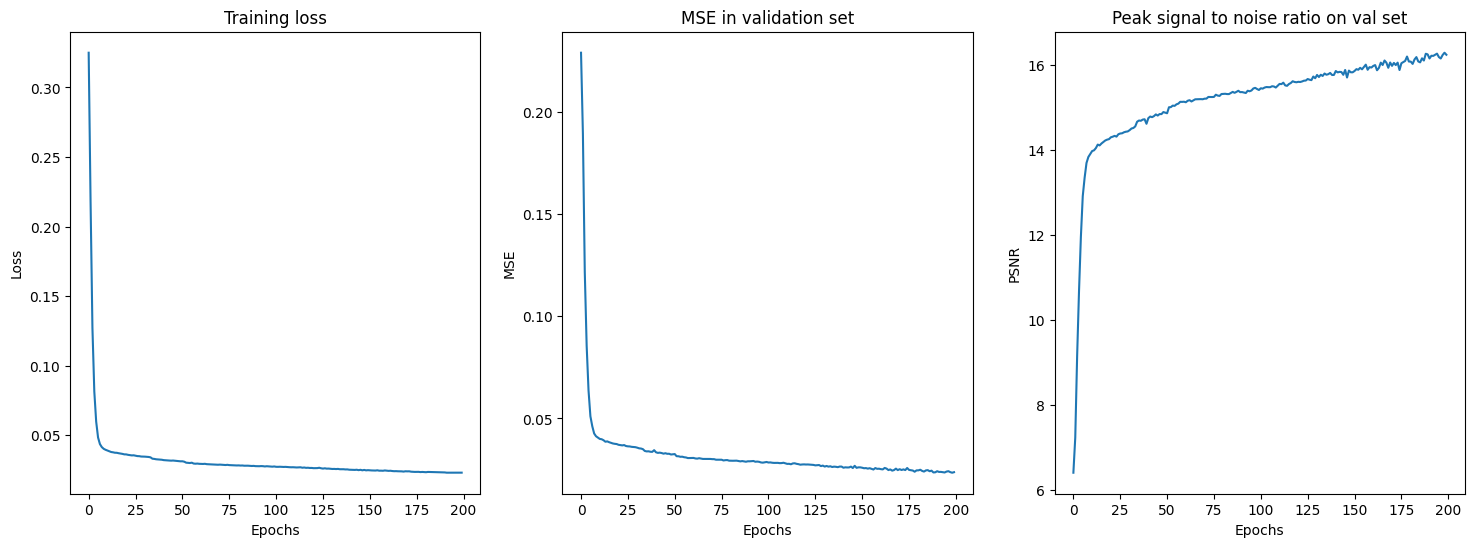

In [26]:
fig, axes = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(18)
axes[0].plot(train_loss)
axes[0].set_title('Training loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')

axes[1].plot(eval_mse)
axes[1].set_title('MSE in validation set')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')

axes[2].plot(eval_psnr)
axes[2].set_title('Peak signal to noise ratio on val set')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('PSNR')

In [27]:
cleaned_DAE = Image.open('../preds/y_cleaned_1.png')
noisy = Image.open('../preds/y_noisy_1.png')
display(noisy)
display(cleaned_DAE)

# 2.Aprendizaje supervisado
### Modelado

Se implementa una arquitectura de red convolucional basado en el paper [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://ieeexplore.ieee.org/document/7839189)

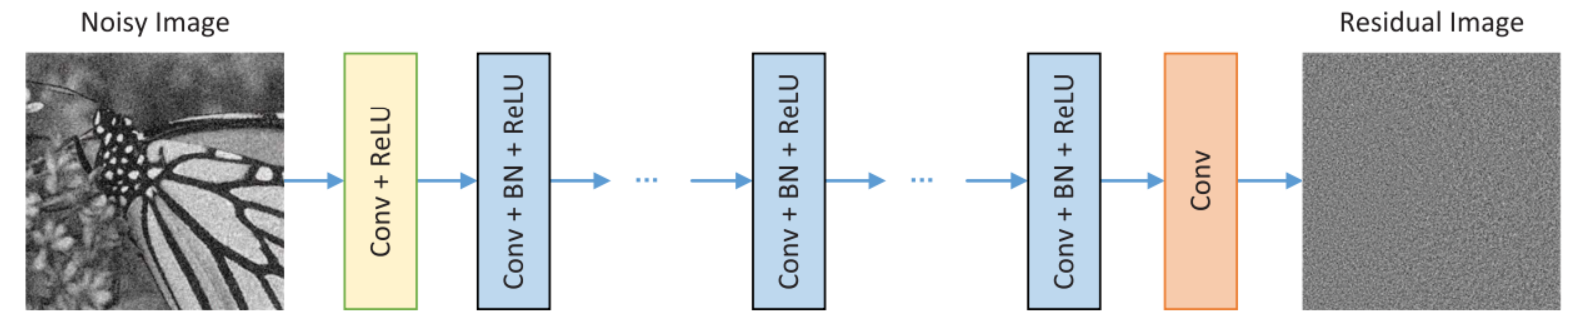

In [12]:
class DnCNN(nn.Module):
    def __init__(self, channels, num_of_layers=10, kernel_size = 3, features_size=64, padding=1, bias=False):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels=channels, out_channels=features_size, kernel_size=kernel_size, padding=padding, bias=bias))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers-2):
            layers.append(nn.Conv2d(in_channels=features_size, out_channels=features_size, kernel_size=kernel_size, padding=padding, bias=bias))
            layers.append(nn.BatchNorm2d(features_size))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=features_size, out_channels=channels, kernel_size=kernel_size, padding=padding, bias=bias))
        self.dncnn = nn.Sequential(*layers)
    def forward(self, x):
        out = self.dncnn(x)
        return out

In [30]:
supervised_model = DnCNN(1)
print(supervised_model)
SAVE_PATH2 = '../preds2/'

DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(64, 64, kernel_size

## Entrenamiento

Se entrena el modelo base DnCnn por 200 épocas

In [33]:
optimizer = optim.Adam(supervised_model.parameters(), lr=LR) 
loss_fn = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()
eval_psnr2 =[]
eval_mse2 = []
train_loss2 = []
checkpoint_path = '../working2/'
p_bar = tqdm(range(EPOCHS))
for epoch in p_bar:
    #print('________________________________________\nEpoch: ', epoch)
    train_loss.append(train_func(train_loader, supervised_model, optimizer, loss_fn, scaler, DEVICE, epoch))
    psnr_avg, mse_avg, psnr_list, mse_list = performance_val(val_loader, supervised_model, DEVICE, SAVE_PATH2)
    eval_psnr.append(psnr_avg)
    eval_mse.append(mse_avg)
    save_preds_as_imgs(test_loader, supervised_model, DEVICE, SAVE_PATH2) 
    checkpoint ={
                    'state_dict' : supervised_model.state_dict(),
                    'optimizer' : optimizer.state_dict()
                }
    filename = checkpoint_path+'checkpoint_'+str(epoch)+'.pth.tar'
    save_checkpoint(checkpoint, filename)
    p_bar.set_postfix(loss=train_loss[-1])
print(f'_____________Evaluation Metrics___________\n')
print(f'Peak Signal to Noise Ratio in val set: {eval_psnr[-1]}')
print(f'MSE: {eval_mse[-1]}')

  0%|          | 0/200 [00:00<?, ?it/s]

_____________Evaluation Metrics___________

Peak Signal to Noise Ratio in val set: 30.585216522216797
MSE: 0.0008739330805838108


## Evaluación
Los resultados de la evaluación del modelo de aprendizaje supervisado son:

```
Peak Signal to Noise Ratio in val set: 30.585216522216797
MSE: 0.0008739330805838108
```

Es importante tener en cuenta que la métrica está en una escála logarítmiza (dB) por lo cual la diferencia entre el modelo DAE y el DnCNN es grande

In [38]:
eval_mse2 = [tensor.cpu() for tensor in eval_mse2]
eval_psnr2 = [tensor.cpu() for tensor in eval_psnr2]

Text(0, 0.5, 'PSNR')

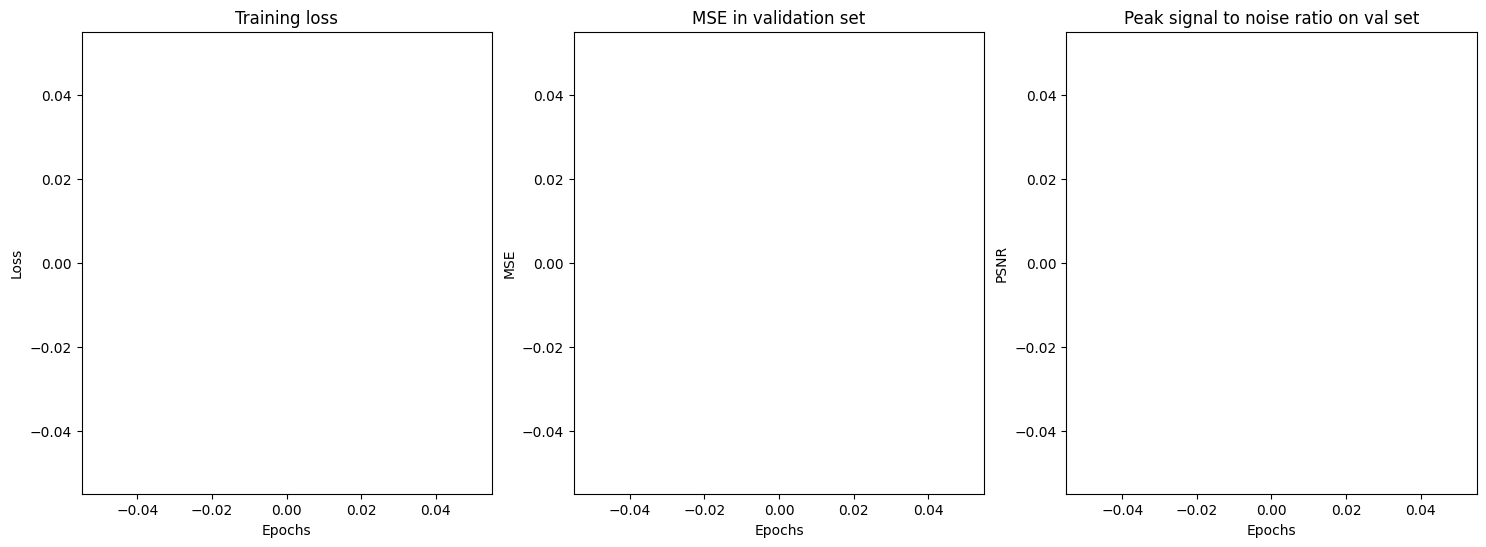

In [39]:
fig2, axes = plt.subplots(1,3)
fig2.set_figheight(6)
fig2.set_figwidth(18)
axes[0].plot(train_loss2)
axes[0].set_title('Training loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')

axes[1].plot(eval_mse2)
axes[1].set_title('MSE in validation set')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')

axes[2].plot(eval_psnr2)
axes[2].set_title('Peak signal to noise ratio on val set')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('PSNR')

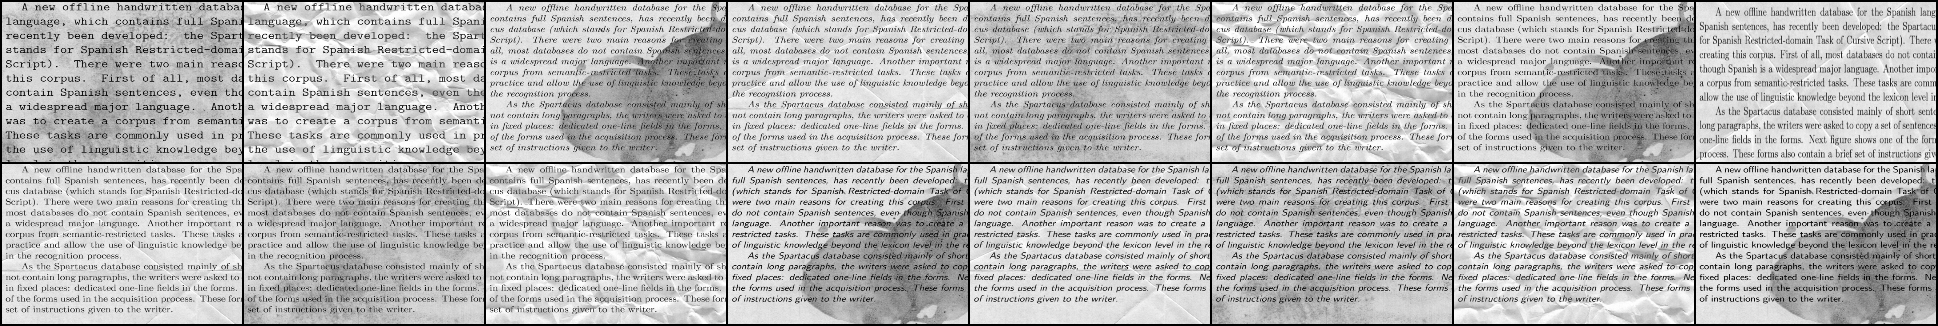

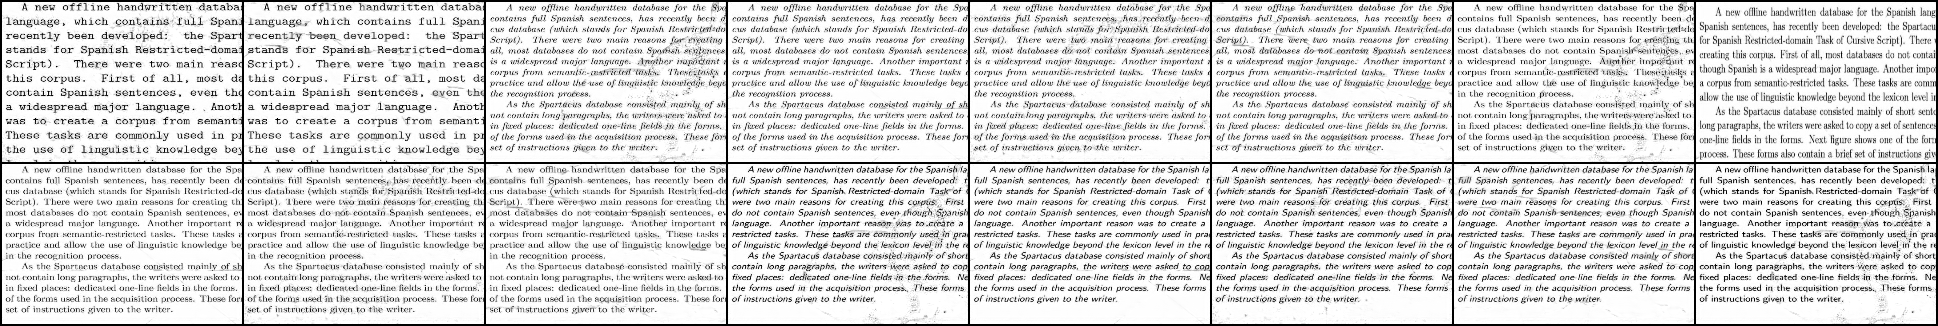

In [20]:
cleaned_DnCNN = Image.open('../preds2/y_cleaned_1.png')
noisy = Image.open('../preds2/y_noisy_1.png')
display(noisy)
display(cleaned_DnCNN)

# 3. Optimización de hiperparámetros
Después de realiazar el modelado, entrenamiento y evaluación de los modelos base, se procede a realizar una optimización de hiperparámetros

- Para el DAE se optimizarán sólo los parámetros learning rate y feature size dado que el kernel, padding, stride cambián el tamaño de las salidas
- Para el mmodelo DnCNN se optimizarán los parámetros: learning rate, num_layers, features_size.

La optimización se hace por medio de la librería optuna y se escoge realizar optimización bayesiana.

In [16]:
import optuna
train_loss3 = []
eval_psnr3 = []
eval_mse3 = []
scaler = torch.cuda.amp.GradScaler()
def objective(trial):
    # Define the search space for hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    feature_size = trial.suggest_int('feature_size', 32, 512)

    # Create the model with the suggested hyperparameters
    un_ho_model = DAE(1, feature_size, KERNEL_SIZE, PADDING)

    # Define the optimizer and loss function
    optimizer = optim.Adam(un_ho_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    p_bar = tqdm(range(25))
    # Train the model and evaluate on the validation set
    for epoch in p_bar:
        train_loss3.append(train_func(train_loader, un_ho_model, optimizer, loss_fn, scaler, DEVICE, epoch))
        psnr_avg3, mse_avg3, psnr_list, mse_list = performance_val(val_loader, un_ho_model, DEVICE, SAVE_PATH)
        eval_psnr3.append(psnr_avg3.cpu())
        eval_mse3.append(mse_avg3.cpu())
        p_bar.set_postfix(loss=train_loss3[-1])
        trial.report(psnr_avg3, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        

    # Return the evaluation metric to optimize (e.g., -psnr_avg)
    return psnr_avg3

# Define the Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

# Run the hyperparameter optimization
study.optimize(objective, n_trials=100, timeout=1800 )

# Get the best hyperparameters and their values
best_params = study.best_params
best_value = study.best_value

print('Best Hyperparameters:', best_params)
print('Best Value:', best_value)

[I 2023-05-26 14:10:45,632] A new study created in memory with name: no-name-7c68ab00-6ccd-4fbd-91dc-42a1a2e29510


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:12:26,426] Trial 0 finished with value: 17.398977279663086 and parameters: {'lr': 0.0002822101391931376, 'feature_size': 188}. Best is trial 0 with value: 17.398977279663086.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:14:15,570] Trial 1 finished with value: 18.27147674560547 and parameters: {'lr': 0.0003773604008811357, 'feature_size': 238}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:15:57,510] Trial 2 finished with value: 16.614564895629883 and parameters: {'lr': 0.0015425907023883824, 'feature_size': 183}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:18:24,933] Trial 3 finished with value: 16.0684871673584 and parameters: {'lr': 0.0192028738311251, 'feature_size': 403}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:19:45,066] Trial 4 finished with value: 10.375568389892578 and parameters: {'lr': 4.692907867488667e-05, 'feature_size': 37}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:19:50,526] Trial 5 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:20:09,887] Trial 6 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:20:25,377] Trial 7 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:20:31,589] Trial 8 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:10,850] Trial 9 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:15,513] Trial 10 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:19,981] Trial 11 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:24,298] Trial 12 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:29,566] Trial 13 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:40,794] Trial 14 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:51,070] Trial 15 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:21:56,678] Trial 16 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:22:05,720] Trial 17 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:22:17,873] Trial 18 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:22:21,774] Trial 19 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:22:26,126] Trial 20 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:24:15,146] Trial 21 finished with value: 17.8477840423584 and parameters: {'lr': 0.001348515214803242, 'feature_size': 191}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:24:19,862] Trial 22 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:26:30,515] Trial 23 finished with value: 17.961811065673828 and parameters: {'lr': 0.0010212971963784543, 'feature_size': 275}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:28:37,537] Trial 24 finished with value: 18.02899169921875 and parameters: {'lr': 0.0012358620214612422, 'feature_size': 274}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:28:42,866] Trial 25 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:28:57,914] Trial 26 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:03,384] Trial 27 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:09,509] Trial 28 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:14,196] Trial 29 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:20,851] Trial 30 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:30,300] Trial 31 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:35,902] Trial 32 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:29:53,454] Trial 33 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:31:52,698] Trial 34 finished with value: 18.153059005737305 and parameters: {'lr': 0.0007244814566484296, 'feature_size': 225}. Best is trial 1 with value: 18.27147674560547.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:32:06,951] Trial 35 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:32:34,810] Trial 36 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:32:40,326] Trial 37 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:33:07,851] Trial 38 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:33:12,996] Trial 39 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:33:17,744] Trial 40 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:33:22,874] Trial 41 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:35:17,912] Trial 42 finished with value: 18.567031860351562 and parameters: {'lr': 0.0007331285037831317, 'feature_size': 189}. Best is trial 42 with value: 18.567031860351562.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:35:26,783] Trial 43 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:35:38,500] Trial 44 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:35:43,431] Trial 45 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:36:10,012] Trial 46 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:36:14,944] Trial 47 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:36:28,150] Trial 48 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:36:34,011] Trial 49 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:36:39,979] Trial 50 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:36:49,166] Trial 51 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:38:42,384] Trial 52 finished with value: 18.16148567199707 and parameters: {'lr': 0.0018555889355275246, 'feature_size': 171}. Best is trial 42 with value: 18.567031860351562.


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:39:00,338] Trial 53 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:39:04,588] Trial 54 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:39:08,703] Trial 55 pruned. 


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-05-26 14:40:58,213] Trial 56 finished with value: 18.18035125732422 and parameters: {'lr': 0.001968768447506421, 'feature_size': 137}. Best is trial 42 with value: 18.567031860351562.


Best Hyperparameters: {'lr': 0.0007331285037831317, 'feature_size': 189}
Best Value: 18.567031860351562


#### Resultados de optimización de hiperparámetros en DAE
**Resultados modelo base sin optimizar y entrenado por 200 épocas**

```
Peak Signal to Noise Ratio in val set: 16.24721336364746
MSE: 0.023728951811790466

```
**Resultados modelo optimizado y entrenado por 25 épocas**
```
Best Hyperparameters: {'lr': 0.0007331285037831317, 'feature_size': 189}
Best Value: 18.567031860351562

```
Se puede observar que sólo con 25 épocas el modelo optimizado obtiene 2 dB más en la métrica de evaluación comparado con el modelo entrenado epor 200 épocas sin optimizar

#### Optimización de hiperparametros de DnCNN

In [ ]:
train_loss4 = []
eval_psnr4 = []
eval_mse4 = []
scaler = torch.cuda.amp.GradScaler()

def objective(trial):
    # Define the search space for hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    features_size = trial.suggest_int('features_size', 32, 128)
    num_of_layers = trial.suggest_int('num_of_layers', 5, 20)

    # Create the model with the suggested hyperparameters
    su_ho_model = DnCNN(1,features_size=features_size, 
                        num_of_layers=num_of_layers)

    # Define the optimizer and loss function
    optimizer = optim.Adam(su_ho_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    p_bar = tqdm(range(25))
    # Train the model and evaluate on the validation set
    for epoch in p_bar:
        train_loss4.append(train_func(train_loader, su_ho_model, optimizer, loss_fn, scaler, DEVICE, epoch))
        psnr_avg4, mse_avg4, psnr_list, mse_list = performance_val(val_loader, su_ho_model, DEVICE, SAVE_PATH)
        eval_psnr4.append(psnr_avg4.cpu())
        eval_mse4.append(mse_avg4.cpu())
        p_bar.set_postfix(loss=train_loss4[-1])
        trial.report(psnr_avg4, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        torch.cuda.empty_cache()
        

    return psnr_avg4

# Define the Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

# Run the hyperparameter optimization
study.optimize(objective, n_trials=100, timeout=2000 )

# Get the best hyperparameters and their values
best_params = study.best_params
best_value = study.best_value

print('Best Hyperparameters:', best_params)
print('Best Value:', best_value)

#### Resultados de optimización de hiperparámetros en DnCNN
**Resultados modelo base sin optimizar y entrenado por 200 épocas**

```
Peak Signal to Noise Ratio in val set: 30.585216522216797
MSE: 0.0008739330805838108

```
**Resultados modelo optimizado y entrenado por 25 épocas**
```
Best Hyperparameters: {'lr': 0.0007983805334830114, 'features_size': 111, 'num_of_layers': 7}
Best Value: 28.289453156479879

```


# 4. Reentrenamiento de modelos post optimización

## 4.1 Denoising Auto Encoder

In [14]:
params_DAE = {'lr': 0.0007331285037831317, 'feature_size': 189}
model = DAE(in_channels=IN_CHANNELS,
            feature_size=params_DAE['feature_size'], 
            kernel_size=KERNEL_SIZE, 
            padding=PADDING)
optimizer = optim.Adam(model.parameters(), lr=params_DAE['lr']) 
loss_fn = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()
eval_psnr =[]
eval_mse = []
train_loss = []
checkpoint_path = '../working/'
p_bar = tqdm(range(EPOCHS))
for epoch in p_bar:
    #print('________________________________________\nEpoch: ', epoch)
    train_loss.append(train_func(train_loader, model, optimizer, loss_fn, scaler, DEVICE, epoch))
    psnr_avg, mse_avg, psnr_list, mse_list = performance_val(val_loader, model, DEVICE, SAVE_PATH)
    eval_psnr.append(psnr_avg.cpu())
    eval_mse.append(mse_avg.cpu())
    save_preds_as_imgs(test_loader, model, DEVICE, '../preds3/') 
    checkpoint ={
                    'state_dict' : model.state_dict(),
                    'optimizer' : optimizer.state_dict()
                }
    filename = checkpoint_path+'checkpoint_OPT'+str(epoch)+'.pth.tar'
    save_checkpoint(checkpoint, filename)
    p_bar.set_postfix(loss=train_loss[-1])
print(f'_____________Evaluation Metrics___________\n')
print(f'Peak Signal to Noise Ratio in val set: {eval_psnr[-1]}')

  0%|          | 0/200 [00:00<?, ?it/s]

_____________Evaluation Metrics___________

Peak Signal to Noise Ratio in val set: 23.419841766357422


Text(0, 0.5, 'PSNR')

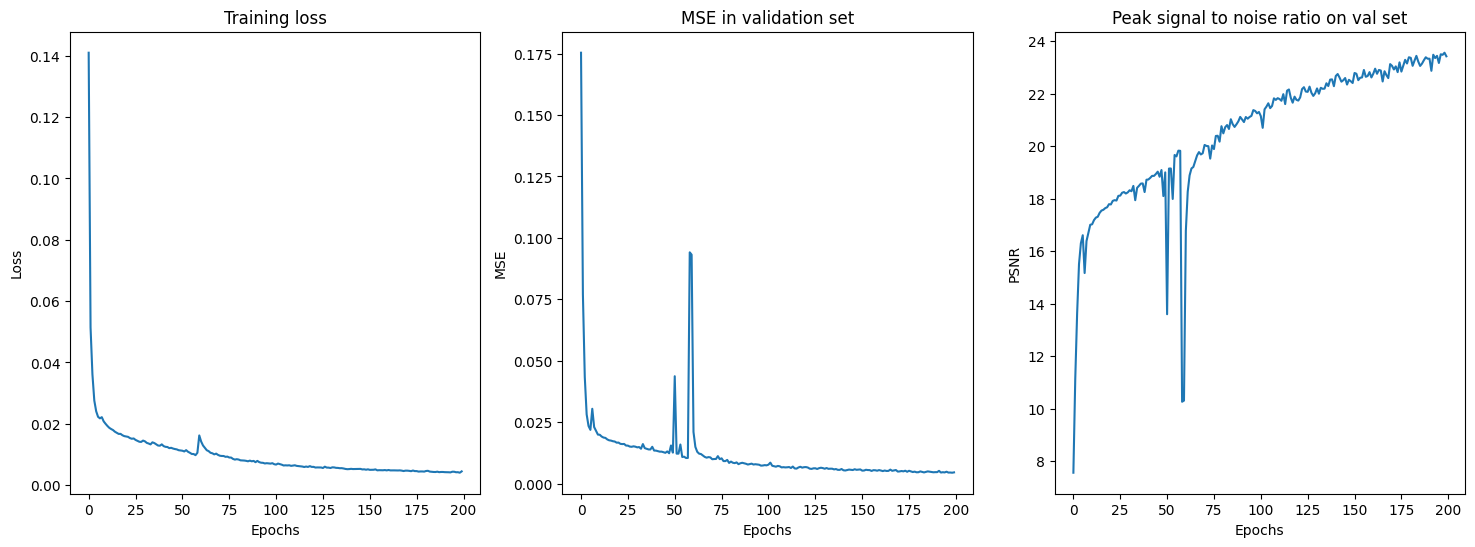

In [15]:
fig, axes = plt.subplots(1,3)
fig.set_figheight(6)
fig.set_figwidth(18)
axes[0].plot(train_loss)
axes[0].set_title('Training loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')

axes[1].plot(eval_mse)
axes[1].set_title('MSE in validation set')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')

axes[2].plot(eval_psnr)
axes[2].set_title('Peak signal to noise ratio on val set')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('PSNR')

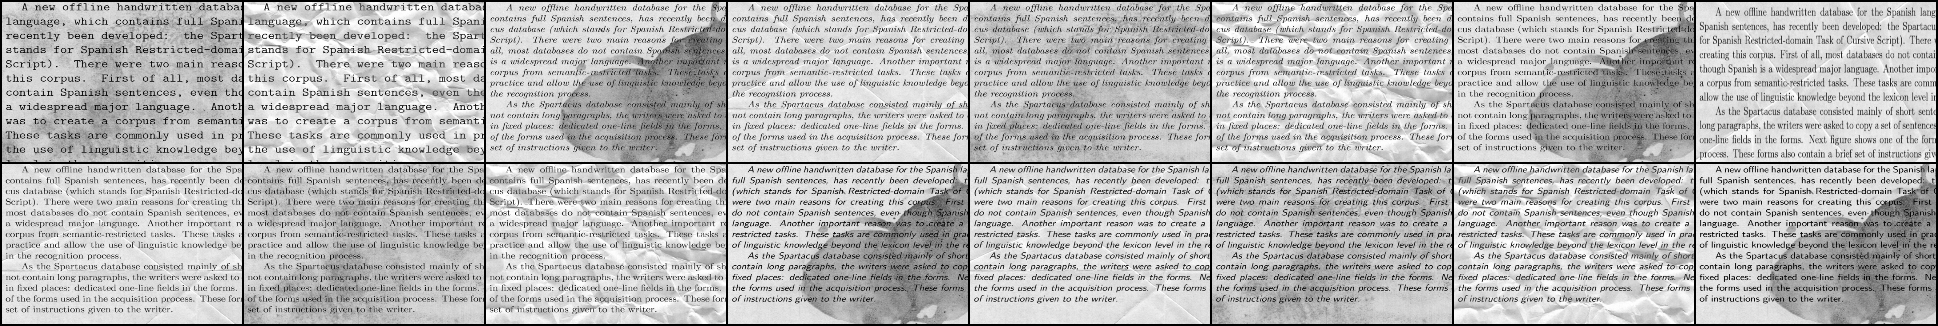

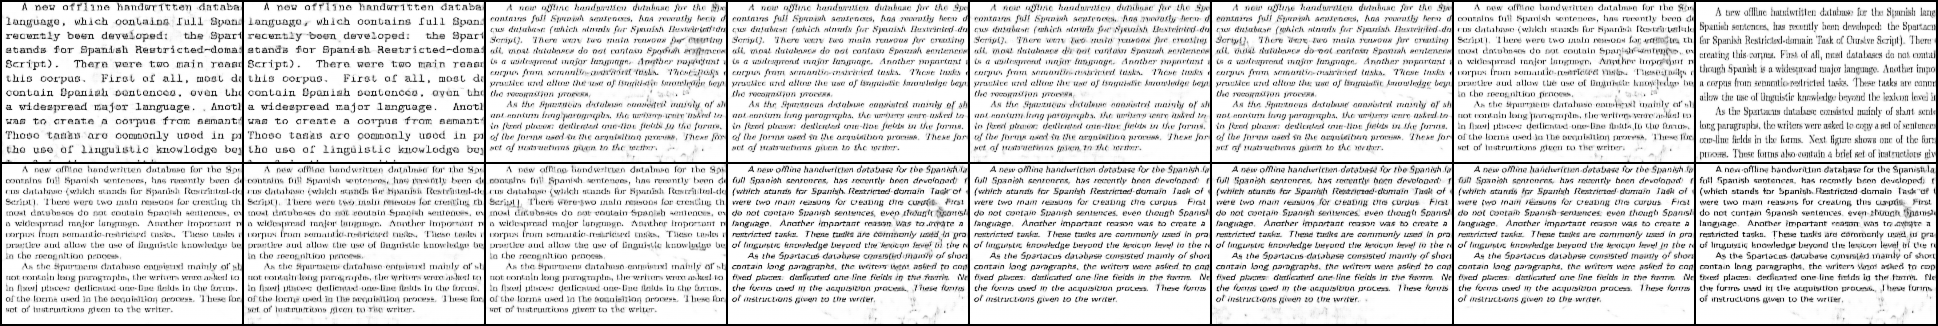

In [16]:
cleaned_DAE = Image.open('../preds3/y_cleaned_1.png')
noisy = Image.open('../preds3/y_noisy_1.png')
display(noisy)
display(cleaned_DAE)

## 4.2 Denoising CNN

In [ ]:
params_DnCNN = {'lr': 0.0007983805334830114, 'features_size': 111, 'num_of_layers': 7}
supervised_model = DnCNN(1, num_of_layers=params_DnCNN['num_of_layers'], features_size=params_DnCNN['features_size'])
SAVE_PATH4 = '../preds4/'

optimizer = optim.Adam(supervised_model.parameters(), lr=params_DnCNN['lr']) 
loss_fn = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler()
eval_psnr2 =[]
eval_mse2 = []
train_loss2 = []
checkpoint_path = '../working2/'
p_bar = tqdm(range(EPOCHS))
for epoch in p_bar:
    #print('________________________________________\nEpoch: ', epoch)
    train_loss2.append(train_func(train_loader, supervised_model, optimizer, loss_fn, scaler, DEVICE, epoch))
    psnr_avg2, mse_avg2, psnr_list, mse_list = performance_val(val_loader, supervised_model, DEVICE, SAVE_PATH4)
    eval_psnr2.append(psnr_avg2.cpu())
    eval_mse2.append(mse_avg2.cpu())
    save_preds_as_imgs(test_loader, supervised_model, DEVICE, SAVE_PATH4) 
    checkpoint ={
                    'state_dict' : supervised_model.state_dict(),
                    'optimizer' : optimizer.state_dict()
                }
    filename = checkpoint_path+'checkpoint_OPT'+str(epoch)+'.pth.tar'
    save_checkpoint(checkpoint, filename)
    p_bar.set_postfix(loss=train_loss2[-1])


In [14]:
print(f'_____________Evaluation Metrics___________\n')
print(f'Peak Signal to Noise Ratio in val set: {eval_psnr2[-1]}')
print(f'MSE: {eval_mse2[-1]}')

_____________Evaluation Metrics___________

Peak Signal to Noise Ratio in val set: 31.01145362854004
MSE: 0.0007922360091470182


Text(0, 0.5, 'PSNR')

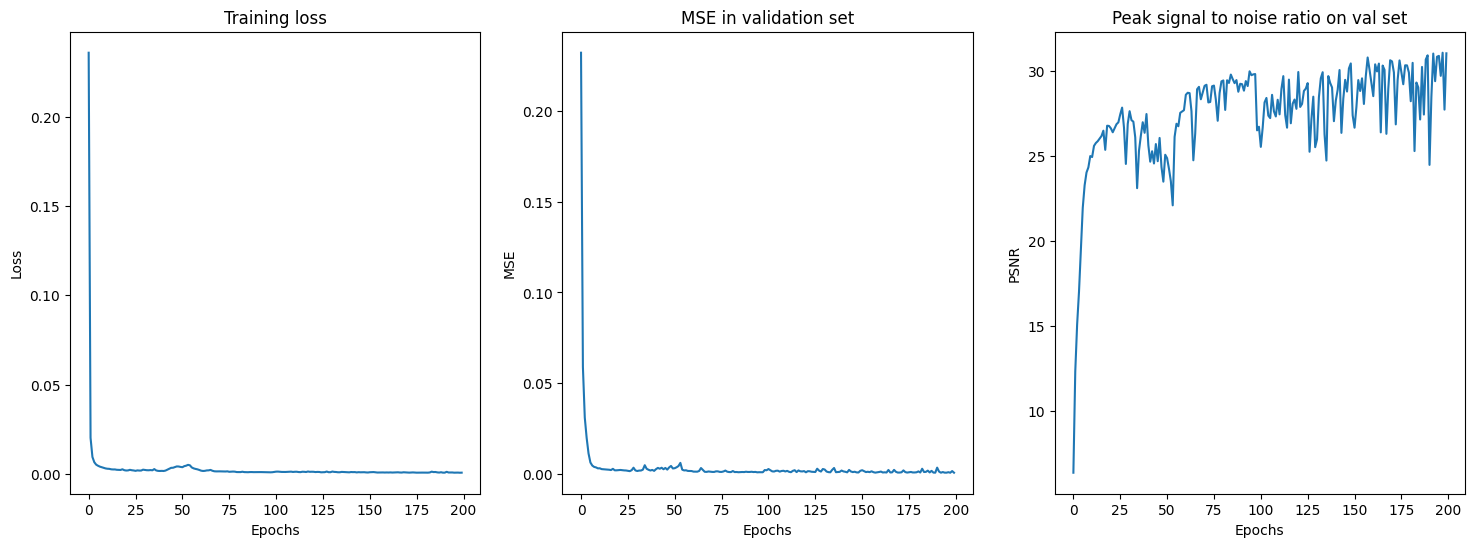

In [15]:
fig2, axes = plt.subplots(1,3)
fig2.set_figheight(6)
fig2.set_figwidth(18)
axes[0].plot(train_loss2)
axes[0].set_title('Training loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')

axes[1].plot(eval_mse2)
axes[1].set_title('MSE in validation set')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('MSE')

axes[2].plot(eval_psnr2)
axes[2].set_title('Peak signal to noise ratio on val set')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('PSNR')

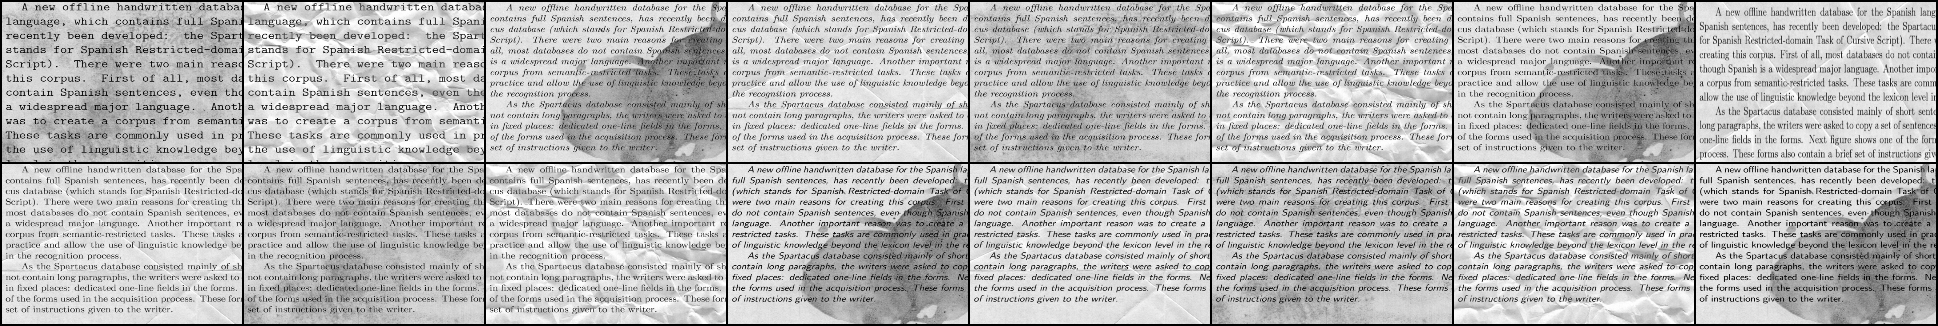

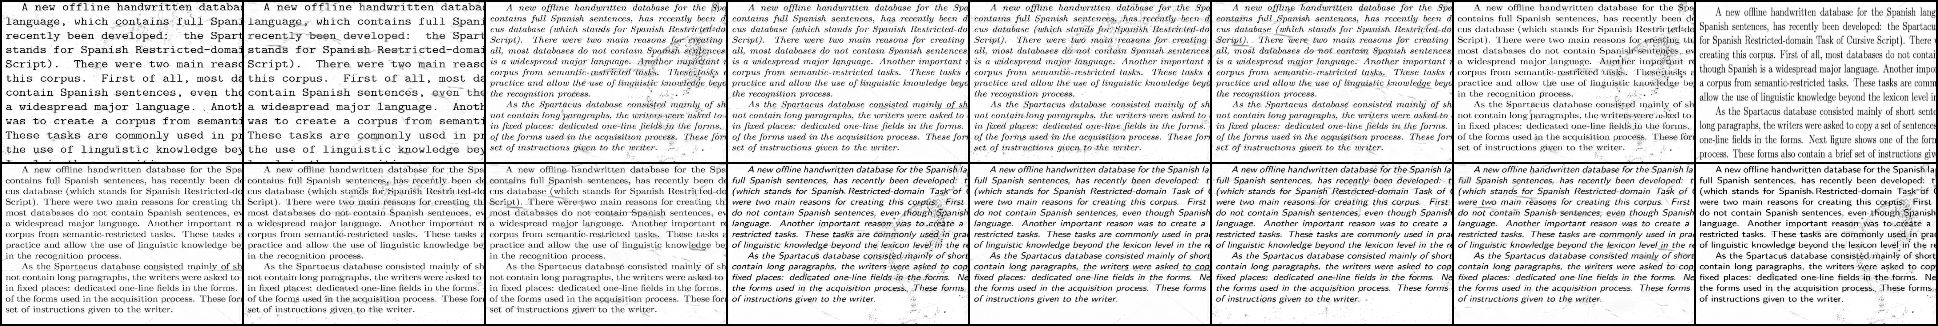

In [21]:
cleaned_DnCNN = Image.open('../preds4/y_cleaned_1.png')
noisy = Image.open('../preds4/y_noisy_1.png')
display(noisy)
display(cleaned_DnCNN)

# Comparación de modelo DnCNN sin optimizar y post-optimización

Las métricas de evaluación del modelo sin optimizar:
```
Peak Signal to Noise Ratio in val set: 30.585216522216797
MSE: 0.0008739330805838108

```
Las métricas de evaluación del modelo optimizado:
```
    Peak Signal to Noise Ratio in val set: 31.01145362854004
    MSE: 0.0007922360091470182
    
```

En la parte superior se muestra las imagenes del modelo sin optmizar, en la de abajo el modelo optimizado, se puede observar que si bien el modelo optimizado tiene mejores métricas, visualmente son muy similares los dos. 

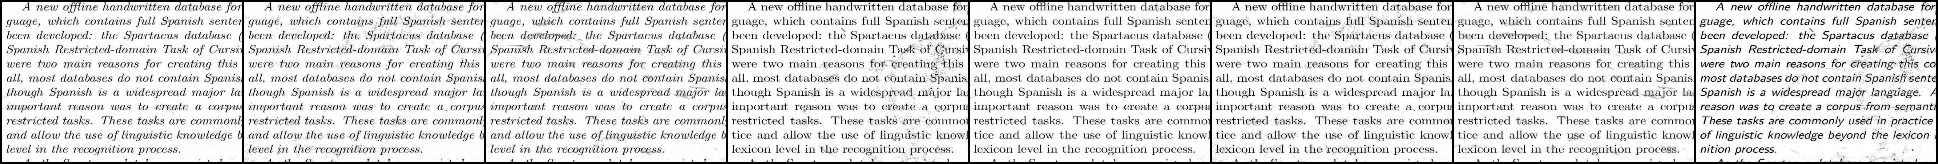

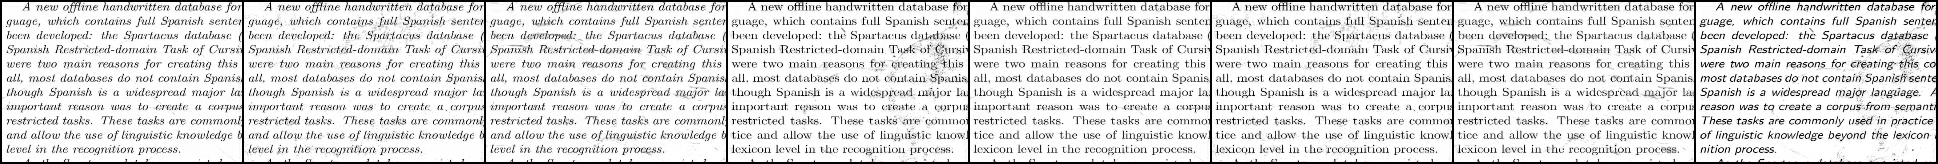

In [25]:
cleaned_DnCNN_NO = Image.open('../preds2/y_cleaned_4.png')
cleaned_DnCNN_O = Image.open('../preds4/y_cleaned_4.png')
display(cleaned_DnCNN_NO)
display(cleaned_DnCNN_O)